In [2]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [3]:
from dataset_creation import dataset_creator as data_generator

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

sns.set(rc={'figure.figsize':(11.7,8.27)})

Total Groups = 115


In [4]:
# TEST Variables
agreeability_thresh=.2
manifest="indiv"
annotators=["Divya", "Nakul"]#, "Swathi"]
zero_mean  = False

test_feats = ["const", "group_sizes"] 

In [5]:
# Annotation Reader
reliable_ids, reliable_convqs, reliable_kappas = data_generator.get_annotation_realiable_labels(agreeability_thresh, manifest, annotators, zero_mean)
print("Total Groups in Analysis - " + str(len(reliable_ids)))

ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False
Total Groups in Analysis - 273


In [6]:
# Get groups sizes (for indiv and group)
group_sizes = data_generator.get_group_sizes_for_ids(reliable_ids, manifest)

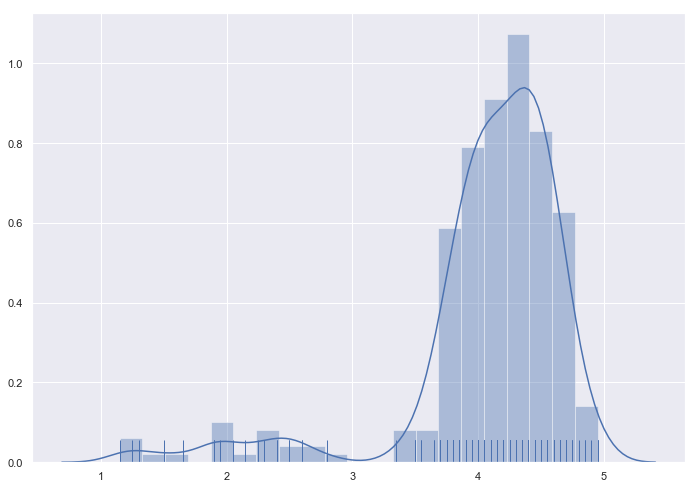

In [7]:
# Plots - Qualitative Analysis
sns.distplot(reliable_convqs, kde=True, rug=True)
plt.show()

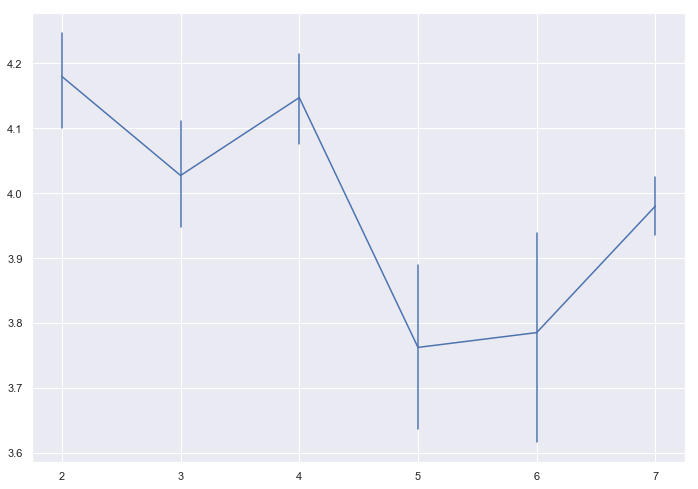

In [10]:
sns.lineplot(x=group_sizes, y=reliable_convqs, err_style="bars", ci=68)

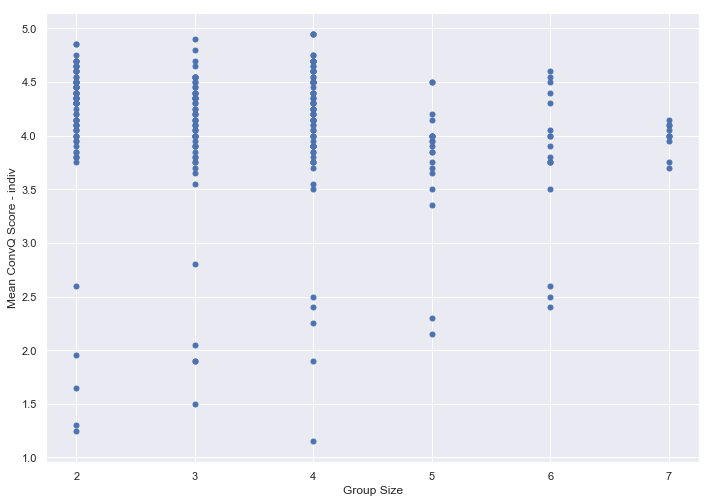

In [11]:
# Scatter Plot - Grp Size Vs ConvQ
plt.scatter(group_sizes, reliable_convqs,s=25,c='b')

plt.ylabel('Mean ConvQ Score - ' + manifest)
plt.xlabel('Group Size')
plt.show()

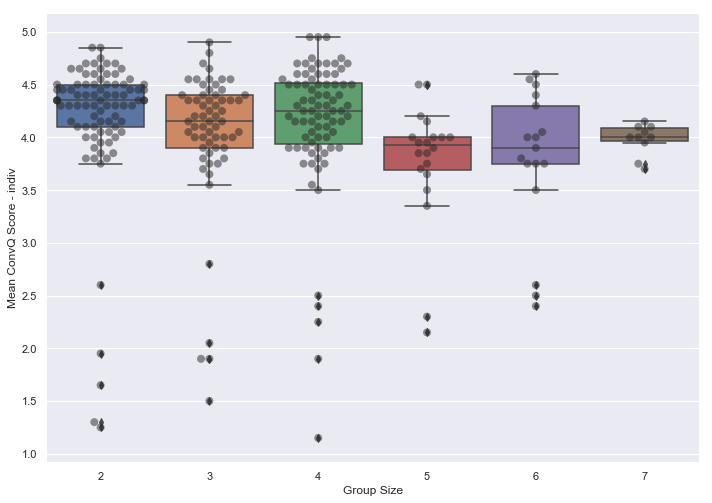

In [12]:
sns.boxplot(group_sizes, reliable_convqs)
sns.swarmplot(group_sizes, reliable_convqs,s=8, color=".15", alpha=0.5)
plt.ylabel('Mean ConvQ Score - ' + manifest)
plt.xlabel('Group Size')
plt.show()

In [13]:
# Dataset Prep
gs_X = pd.DataFrame(data=group_sizes, index=reliable_ids, columns=["group_sizes"]) 
gs_X["convq"] = reliable_convqs

In [63]:
# Experiment Below

# Statistical Test for: (Main Question)
# Does group-size have an effect on the Perceived Individual's Experience of Conversation Quality?
# 
# 1. Validate Significance @ p<0.05 using a Quantile Least Square based Regression (group_size Vs ConvQ)
# 2. Validate futher for Significance @ p<0.05 with pairs of group-sizes. (Pairwise Quantile LS Tests)
# 3. Check the co-efficients for relationships.

# Quantile Regression
X = sm.add_constant(gs_X)
model = sm.GLM(X["convq"], X.loc[:,test_feats], family=sm.families.Gamma())
# model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,test_feats])
# model = sm.OLS(X["convq"], X.loc[:,test_feats])


results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  convq   No. Observations:                  273
Model:                            GLM   Df Residuals:                      271
Model Family:                   Gamma   Df Model:                            1
Link Function:          inverse_power   Scale:                        0.025811
Method:                          IRLS   Log-Likelihood:                -333.80
Date:                Sun, 31 May 2020   Deviance:                       10.500
Time:                        15:41:02   Pearson chi2:                     6.99
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2312      0.007     35.259      

/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [59]:
# Pairwise Quantile Regression
unique_groups = np.unique(X.loc[:,"group_sizes"].values)
print("Total Number of Tests -> " + str(len(list(itertools.combinations(unique_groups,2)))))
for pair in list(itertools.combinations(unique_groups,2)):
    pairwise_X = X.loc[X["group_sizes"].isin(list(pair))]
    model = sm.OLS(pairwise_X["convq"], pairwise_X.loc[:,test_feats])
    results = model.fit(q=.5)
    print("Current Pair -> " + str(list(pair)))
    print(results.summary())

Total Number of Tests -> 15
Current Pair -> [2, 3]
                            OLS Regression Results                            
Dep. Variable:                  convq   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.807
Date:                Sun, 31 May 2020   Prob (F-statistic):              0.181
Time:                        15:18:55   Log-Likelihood:                -148.87
No. Observations:                 146   AIC:                             301.7
Df Residuals:                     144   BIC:                             307.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                  convq   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     4.229
Date:                Sun, 31 May 2020   Prob (F-statistic):             0.0425
Time:                        15:18:55   Log-Likelihood:                -96.079
No. Observations:                  97   AIC:                             196.2
Df Residuals:                      95   BIC:                             201.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.8700      0.388     12.543      